<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L06/CVaR_portfolio_optim_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Portfolio Return and Loss Calculation  

Extended from https://blog.quantinsti.com/cvar-expected-shortfall/

Author R.Rocchetta
Date: 25/03/2025

The first part of this code analyzes the performance of a portfolio containing three assets:

* 40% Amazon (AMZN),
* 30% Tesla (TSLA),
* 30% Apple (AAPL)

Initial portfolio value is: 1,000,000

## Learning Goals:
- Data exploration and visualization
- Estimate VaR and CVaR using
  - Directly from empirical data
  - Gaussian assumption empirical moments

- The student will learn how to define a greedy search algorithm
- The goal is to find
  - Good VaR constrained solution
  - Good CVaR constrained solutions (a portfolio)

-Discuss advantages and disadvantages of both constraints

In [3]:
import numpy as np
import pandas as pd # library for data analysis
import yfinance as yf  # we will load the data from here
from scipy.stats import norm
import matplotlib.pyplot as plt

# ANSI escape codes for color formatting
RESET = "\033[0m"
GREEN = "\033[92m"
BLUE = "\033[94m"
RED = "\033[91m"
CYAN = "\033[96m"
YELLOW = "\033[93m"

## Portfolio analysis steps.....

1. **Data Download**:  Using `yfinance`, the historical daily closing of AMZN, TSLA, and AAPL are downloaded for the specified period

2. **Data Preparation**: Combine into a single DataFrame `df`
   
3. **Return Calculation**: The daily returns for each stock are calculated using the percentage change in closing prices. The returns are then negated (indicated by `-pct_change()`), as the script aims to compute losses (negative returns).
   
$$
\text{Percentage Change}_t = \frac{\text{Value}_t - \text{Value}_{t-1}}{\text{Value}_{t-1}} \times 100
$$

4. **Portfolio Construction**: a weighted portfolio created using the returns of the individual stocks based on an array of normalized weights (`w`). Returns (`Rp`) are calculated as the weighted sum of individual stock returns.

5. **Portfolio Value**: An initial portfolio value of 1,000,000 is set (`W`), and the cumulative returns are used to compute the portfolio value over time. The value is updated daily by multiplying the initial value by the cumulative product of 1 + daily returns. If the portfolio starts with an initial value and experiences daily returns $R_t$, the portfolio value at time $t$ is calculated as $
\text{Portfolio}_t = W \times \prod_{i=1}^{t} (1 + R_i)
$  where $R_t$ represents the portfolio return on day $t$. The meaning is that the daily gains and losses affect the base for future returns. The cumulative product ensures that each day's return builds upon the previous days.
  
6. **Loss Calculation**: The losses are computed as the difference between the initial portfolio value and the current portfolio value for each day, stored in the `L` column.

#### The output of this procedure yields:
- A final DataFrame `df` containing:
  - Your prtfolio values over time (`Portfolio`)
  - Your daily losses accordingly to the percentage of change in the closing values of the stocks (`L`)
  - The weighted portfolio return on each day (`Rp`)

This analysis allows tracking how a portfolio of these three assets performs over time and calculates the losses incurred compared to the initial portfolio value.


In [ ]:
# 1 Download the data
Stock_names= ['AMZN', 'TSLA', 'AAPL']

amzn = yf.download('AMZN', '2023-11-30', '2024-11-30')
tsla = yf.download('TSLA', '2023-11-30', '2024-11-30')
aapl = yf.download('AAPL', '2023-11-30', '2024-11-30')

# 2 Extract only closing prices
amzn_close = amzn['Close']
tsla_close = tsla['Close']
aapl_close = aapl['Close']

# Put all three closing prices together
df = pd.concat([amzn_close, tsla_close, aapl_close], axis=1)
df.columns = ['AMZN', 'TSLA', 'AAPL']

# 3. Compute the returns as percentage of change
df['R1'] = -df['AMZN'].pct_change(fill_method=None)
df['R2'] = -df['TSLA'].pct_change(fill_method=None)
df['R3'] = -df['AAPL'].pct_change(fill_method=None)

df_copy_raw = df.copy()
# df.head(1000)

In [5]:
df = df_copy_raw.copy() # copy the initial raw data

# 4. Construct the portfolio returns column as a weighted sum of individual asset returns and weights
w = np.array([0.4, 0.3, 0.3])
df['Rp'] = (df[['R1', 'R2', 'R3']] * w).sum(axis=1)
df = df.drop(df.index[0]) # remove first NaNs

# Add the Portfolio column with an initial value of 1,000,000 CHF
W = 1000000
df['Portfolio'] = W * (1 + df['Rp']).cumprod()

# Compute losses and add as a column to df
df['L'] = W - df['Portfolio']  # computed as initial investment - portfolio value
# df[['Portfolio', 'Rp', 'L']].head(1000)

In [ ]:
# Compute VaR(zero)
alpha = 0.05
VaR_level_w0 = df['L'].quantile(1-alpha)

print('Value at Risk (Empirical) at confidence/probab level {:.2f} is: {:.2f} kCHF'.format(1-alpha, VaR_level_w0/1000))
print(df['L'].quantile(1-alpha) )
print(W - df['Portfolio'].quantile(alpha))# equivalent...


In [ ]:
# Value at Risk (VaR) analytical (assuming gaussian)
VaR_analytic_w0 = df['L'].mean() + df['L'].std() * norm.ppf(1-alpha)
print('Value at Risk (analytical Gaussian assumption) is: {:.2f}'.format(VaR_analytic_w0))

In [10]:
#@title define 2 useful function

# Calculate the VaR, ES, Expected Profit, and Loss profile based on your investment:
def get_VaR_and_ES(w_selected, alpha=0.05):
  """ Repeat the analysis for any weight array (w) and alpha in [0,1]"""

  df = df_copy_raw.copy() # copy the initial raw data
  df['Rp'] = (df[['R1', 'R2', 'R3']] * w_selected).sum(axis=1)
  df['Portfolio'] = W * (1 + df['Rp']).cumprod()
  df['L'] = W - df['Portfolio']
  VaR_optimal = df['L'].quantile(1-alpha)
  ES_optimal = df.loc[df['L'] > VaR_optimal, 'L'].mean()
  Expected_Loss = df['L'].mean()

  return VaR_optimal, ES_optimal, Expected_Loss, df['L']

# estimate empirical CDF of univariate data
def ecdf_data(data):
  x = np.sort(data)
  ecdf = np.arange(1, len(data)+1) / len(data)
  return x, ecdf

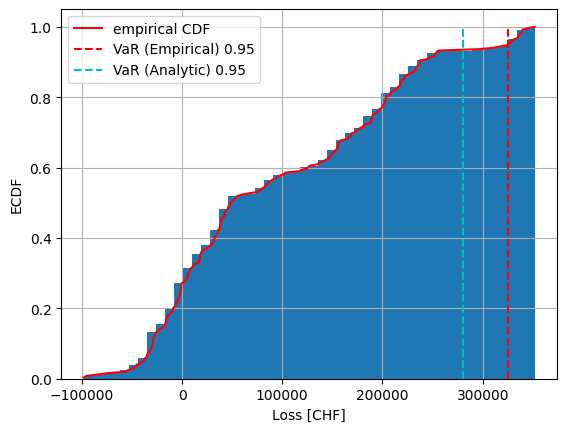

In [11]:
#@title Visualize pdf and cdf of the loss function and estiamte Value at Risk

df['L'].hist(bins=50, density=True, cumulative=True) # show cdf of daily losses
loss, ecdf = ecdf_data(df['L'])
plt.plot(loss, ecdf, 'r', label='empirical CDF')
plt.vlines(VaR_level_w0, 0, 1, colors='r', linestyles='dashed', label=f'VaR (Empirical) {1-alpha}')
plt.vlines(VaR_analytic_w0, 0, 1, colors='c', linestyles='dashed', label=f'VaR (Analytic) {1-alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend()
plt.show()

# Analytical vs empirical CVaR estimation

In [12]:
# Expected Shortfall analytical (assuming gaussian)
ES_analytic_w0 = df['L'].mean() + df['L'].std() * norm.pdf(norm.ppf(1-alpha)) / (alpha)
print('Expected Shortfall (analytical Gaussian assumption) is: {:.2f}'.format(ES_analytic_w0))

# Expected Shortfall (Conditional Value at Risk)
ES_empirical_w0 = df.loc[df['L'] > VaR_level_w0, 'L'].mean()
print('Expected Shortfall (empirical) is: {:.2f}'.format(ES_empirical_w0))

Expected Shortfall (analytical Gaussian assumption) is: 327669.07
Expected Shortfall (empirical) is: 336512.57


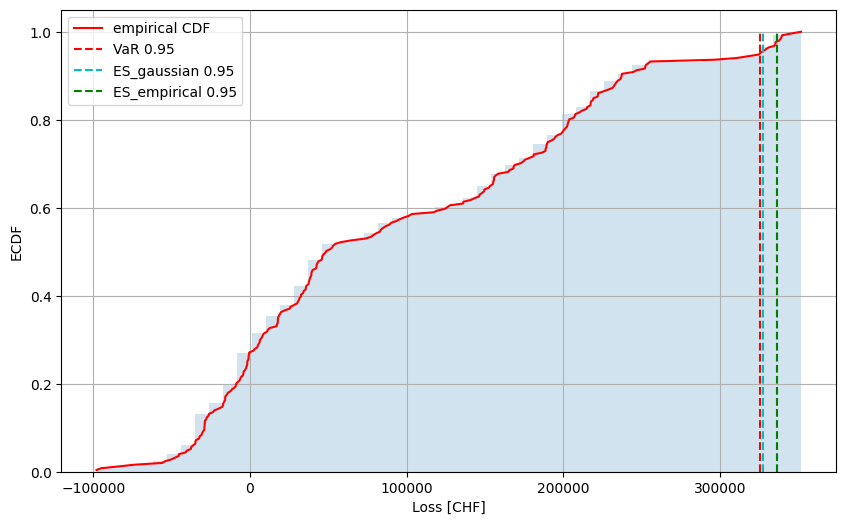

In [13]:
#@title visualize cdf of the loss function, VaR and ES for the base case
import matplotlib.pyplot as plt

Loss_base = df['L'].copy()
loss, ecdf = ecdf_data(Loss_base)

# add vertical lines for the VaR, Expected Shortfall (parametric and empirical)
plt.figure(figsize=(10, 6))
Loss_base.hist(bins=50, density=True, cumulative=True, alpha=0.2) # show cdf of daily losses
plt.plot(loss, ecdf, 'r', label='empirical CDF')
plt.vlines(VaR_level_w0, 0, 1, colors='r', linestyles='dashed', label=f'VaR {1-alpha}')
plt.vlines(ES_analytic_w0, 0, 1, colors='c', linestyles='--', label=f'ES_gaussian {1-alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='g', linestyles='dashed', label=f'ES_empirical {1-alpha}')

plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend()
plt.show()

# Greedy Search Portfolio Optimization with VaR Constraint

This cell implements a greedy search algorithm that uses random portfolio generation to find the optimal portfolio weights. The goal is to minimize the expected loss while ensuring that the portfolio's Value at Risk (VaR) does not exceed a predefined threshold.

## Objective
We want to solve:
$$
\min_{w} \, \mathbb{E}[\text{Loss}(w)] \quad \text{subject to} \quad \text{VaR}_{1-\alpha}(\text{Loss}(w)) \leq \text{VaR}_{\text{max}}
$$
where:
- $w$ represents the portfolio weights.
- $\text{Loss}(w)$ is the portfolio loss function.
- $\text{VaR}_{\text{max}}$ is the maximum allowable loss at the probability level $\alpha=0.05$.

## Code Procedure
- **1. Objective Function (`obj_fun_VaR`)**:  
  Computes the expected loss for a given set of weights $w$ while calculating the portfolio returns, cumulative portfolio value, and corresponding loss. If the computed VaR exceeds the threshold, it penalizes the solution by returning an infinite loss.


- **2. Greedy Search (`for _ in range(num_samples)`)**:  
  a. Randomly generates candidate portfolios (ensuring weights sum to 1) over 1,000 iterations.

  b. Selects the portfolio that minimizes the expected loss while satisfying the VaR constraint.


- **3. Result Post-Processing and Reporting**:  
  The optimal weights, minimized expected loss, and VaR for the optimal portfolio are printed. Additionally, the Expected Shortfall is computed using both analytical and empirical methods for further comparison with a base case.

In [ ]:
# 1. Define optimization objective (minimize expected loss while constraining VaR)
def obj_fun_VaR(w, VaR_threshold, alpha=0.05):
    """Compute expected loss for given weights `w` and ensure VaR is below threshold.

    w: the proposed design
    VaR_threshold: the maximum allowed loss level (constraint)
    alpha: selected probability level

    """
     # COMPLETE CODE
     # objective function
     # retur the VaR is acceptable
     # return inf if the VaR level is too high.


# Define model parameters....let see if we can do better than the base case w0.
w0 = np.array([0.4, 0.3, 0.3])  # Initial guess for weights
alpha = 0.1  # probability level

VaR_threshold = VaR_level_w0  # This means we do not accept loss higher than reference for the base case
min_expected_loss = float('inf')  # initialize a high objective function
best_w_VaR_EL = w0  # initialize best portfolio

### 2. START GREEDY SEARCH

num_samples = 100 # Number of samples for greedy search
for _ in range(num_samples):

    # a Sample a new set of weights
    # COMPLETE CODE


    # b Compute expected loss ..... check if VaR constraint are sattisfied
    # COMPLETE CODE

    # Update best weights if the current candidate has a lower expected loss and
    # satisfies the VaR constraint

# Calculate the Value at Riks (VaR), Conditional VAR (ES) for the optimized portfolio investment (w)


In [17]:

# Define optimization objective (minimize expected loss while constraining VaR)
def obj_fun_VaR(w, VaR_threshold, alpha=0.05):
    """Compute expected loss for given weights `w` and ensure VaR is below threshold.
    w: the proposed design
    VaR_threshold: the maximum allowed loss level (constraint)
    alpha: selected probability level
    """

    VaR, ES, Expected_Loss, _ = get_VaR_and_ES(w, alpha=alpha)

    if VaR <= VaR_threshold:
        return Expected_Loss # objective function (minimize loss -> max profit)

    else:
        return float('inf')  # Penalize solutions with VaR above the threshold


# Define model parameters....let see if we can do better than the base case w0.
w0 = np.array([0.4, 0.3, 0.3])  # Initial guess for weights
best_w_VaR_EL = w0  # initialize best portfolio
alpha = 0.1  # probability level
VaR_level_w0, ES_empirical_w0, expected_base_w0, Loss_base = get_VaR_and_ES(w0, alpha=alpha)
VaR_threshold = VaR_level_w0  # This means we do not accept loss higher than reference for the base case
min_expected_loss = float('inf')  # initialize a high objective function


"""VaR_level_w0 = Loss_base.quantile(1-alpha)  #  value at risk for the selected alpha
ES_empirical_w0 = Loss_base.loc[Loss_base > VaR_level_w0].mean()  #  right tail risk for the selected alpha
expected_base = Loss_base.mean()
ES_analytic_w0 =expected_base + Loss_base.std() * norm.pdf(norm.ppf(1-alpha)) / (alpha)"""



###START GREEDY SEARCH

num_samples = 1_000 # Number of samples for greedy search
for _ in range(num_samples):

    # a Sample a new set of weights
    w_candidate = np.random.rand(3)
    w_candidate /= np.sum(w_candidate)  # Normalize to sum to 1

    # b Compute expected loss and check VaR constraint
    expected_loss_candidate = obj_fun_VaR(w_candidate, VaR_threshold, alpha=alpha)

    # Update best weights if the current candidate has a lower expected loss and
    # satisfies the VaR constraint
    if expected_loss_candidate < min_expected_loss:
        min_expected_loss = expected_loss_candidate
        best_w_VaR_EL = w_candidate

VaR_optimal, ES_optimal, _, Loss_optim_VAR  = get_VaR_and_ES(best_w_VaR_EL, alpha)

In [ ]:
VaR_optimal, ES_optimal, _, Loss_optim_VAR  = get_VaR_and_ES(best_w_VaR_EL, alpha)

# Results with color formatting
print(f"\n Expected Loss Optimization with CVaR Constraint (Greedy Search):")
print(f"\n Optimal weights:{BLUE}{best_w_VaR_EL.round(3)}{RESET} ")
print(f"\n Minimized Expected Loss: {GREEN}{min_expected_loss:.2f}{RESET} vs {RED}{expected_base_w0:.2f}{RESET} CHF of the base case")
print(f'\n VaR for optimal weights: {GREEN}{VaR_optimal:.2f} vs {VaR_level_w0:.2f}{RESET} CHF of the base case')
print(f'\n Expected Shortfall (empirical) is {RED}{ES_optimal:.2f}{RESET} vs {ES_empirical_w0:.2f} CHF of the base case')



In [ ]:
#@title visualize cdf of the loss function, VaR and ES for the optimized case
loss, ecdf = ecdf_data(Loss_base)

plt.plot(loss, ecdf, 'r', label='ECDF base case')
plt.vlines(VaR_level_w0, 0, 1-alpha, colors='r', linestyles='--', label=f'VaR {1-alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='r', linestyles=':', label=f'ES_empirical {1-alpha}')

loss, ecdf = ecdf_data(Loss_optim_VAR)
plt.plot(loss, ecdf, 'b', label='ECDF optim ')
plt.vlines(VaR_optimal, 0, 1-alpha, colors='b', linestyles='--', label=f'VaR optim {1-alpha}')
plt.vlines(ES_optimal, 0, 1, colors='b', linestyles=':', label=f'ES_emp optim {1-alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend(loc='upper left')
plt.grid()
plt.show()

loss, ecdf = ecdf_data(Loss_base)
plt.plot(loss, ecdf, 'r', label='ECDF base case')
plt.vlines(VaR_level_w0, 0, 1-alpha, colors='r', linestyles='--', label=f'VaR (base case) {1-alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='r', linestyles=':', label=f'ES (base case)  empirical {1-alpha}')

loss, ecdf = ecdf_data(Loss_optim_VAR)
plt.plot(loss, ecdf, 'b', label='ECDF optim ')
plt.vlines(VaR_optimal, 0, 1-alpha, colors='b', linestyles='--', label=f'VaR optim {1-alpha}')
plt.vlines(ES_optimal, 0, 1, colors='b', linestyles=':', label=f'ES_emp optim {1-alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend(loc='lower left')
plt.grid()
plt.yticks([0.8,0.9,1.0])
plt.xlim(100_000,600_000)
plt.show()

# Greedy Search Portfolio Optimization with CVaR Constraint


## Objective
We want to solve:
$$
\min_{w} \, \mathbb{E}[\text{Loss}(w)] \quad \text{subject to} \quad \text{ES}_{1-\alpha}(\text{Loss}(w)) \leq \text{VaR}_{\text{max}}
$$
where:
- $w$ represents the portfolio weights.
- $\text{Loss}(w)$ is the portfolio loss function.
- $\text{VaR}_{\text{max}}$ is the maximum allowable loss level



In [22]:
# Define optimization objective (minimize expected loss while constraining VaR)
def obj_fun_Tail_Expectation(w, VaR_threshold, alpha):
    """Compute expected loss for given weights `w` and ensure VaR is below threshold."""

    # COMPLETE CODE
    # SAME AS FOR THE PREVIOUS CASE
    # BUT THIS TIME WE USE EXPECTED SHORTFALL AS CONSTRAINT
    return []

# Define model parameters....let see if we can do better than the base case w0.
w0 = np.array([0.4, 0.3, 0.3])  # Initial guess for weights

alpha = 0.1  # probability level
VaR_level_w0, ES_empirical_w0, expected_base_w0, Loss_base = get_VaR_and_ES(w0, alpha=alpha)

best_w_ES_EL = w0  # initialize best portfolio
VaR_threshold = VaR_level_w0  # This means we do not accept loss higher than reference for the base case
min_expected_loss = float('inf')  # initialize a high objective function

# Number of samples for greedy search
num_samples = 2_000
for _ in range(num_samples):
    # Sample a new set of weights
    w_candidate = np.random.rand(3)
    w_candidate /= np.sum(w_candidate)  # Normalize to sum to 1

    # Compute expected loss and check VaR constraint
    expected_loss_candidate = obj_fun_Tail_Expectation(w_candidate, VaR_threshold, alpha=alpha)

    # Update best weights if the current candidate has a lower expected loss and
    # satisfies the VaR constraint
    if expected_loss_candidate < min_expected_loss:
        min_expected_loss = expected_loss_candidate
        best_w_ES_EL = w_candidate
 # ANSI escape codes for color

In [ ]:
VaR_optimal, ES_optimal, min_expected_loss, Loss_optim_ES  = get_VaR_and_ES(best_w_ES_EL, alpha)

# Results with color formatting
print(f"\n Expected Loss Optimization with CVaR Constraint (Greedy Search):{RESET}")
print(f"\n {BLUE}Minimized Expected Loss:{RESET} {min_expected_loss:.2f}{RESET}  vs {RED}{expected_base_w0:.2f}{RESET} CHF of the base case")

print(f"\n Minimized Expected Loss: {GREEN}{min_expected_loss:.2f}{RESET} vs {RED}{expected_base_w0:.2f}{RESET} CHF of the base case")
print(f'\n VaR for optimal weights: {GREEN}{VaR_optimal:.2f}{RESET} vs {RED}{VaR_level_w0:.2f}{RESET} CHF of the base case')
print(f'\n Expected Shortfall (empirical) is {GREEN}{ES_optimal:.2f}{RESET} vs {RED}{ES_empirical_w0:.2f}{RESET} CHF of the base case')


In [ ]:
#@title visualize cdf of the loss function, VaR and ES for the optimized case
loss, ecdf = ecdf_data(Loss_base)
plt.plot(loss, ecdf, 'r', label='ECDF base case')
plt.vlines(VaR_level_w0, 0, 1-alpha, colors='r', linestyles='--', label=f'VaR {alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='r', linestyles=':', label=f'ES_empirical {alpha}')

loss, ecdf = ecdf_data(Loss_optim_ES)
plt.plot(loss, ecdf, 'b', label='ECDF optimized')
plt.vlines(VaR_optimal, 0, 1-alpha, colors='b', linestyles=':', label=f'VaR {alpha}')
plt.vlines(ES_optimal, 0, 1, colors='b', linestyles='--', label=f'ES_empirical {alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend(loc='upper left')
plt.grid()
plt.show()

loss, ecdf = ecdf_data(Loss_base)
plt.plot(loss, ecdf, 'r', label='ECDF base case')
plt.vlines(VaR_level_w0, 0, 1-alpha, colors='r', linestyles='--', label=f'VaR (base case) {1-alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='r', linestyles=':', label=f'ES (base case)  empirical {1-alpha}')

loss, ecdf = ecdf_data(Loss_optim_ES)
plt.plot(loss, ecdf, 'b', label='ECDF optim ')
plt.vlines(VaR_optimal, 0, 1-alpha, colors='b', linestyles='--', label=f'VaR optim {1-alpha}')
plt.vlines(ES_optimal, 0, 1, colors='b', linestyles=':', label=f'ES_emp optim {1-alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend(loc='lower left')
plt.grid()
plt.yticks([0.8,0.9,1.0])
plt.xlim(100_000,400_000)
plt.show()